<a href="https://colab.research.google.com/github/Ihsan1331/document-tagging/blob/main/Multilabel_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Load Package

In [81]:
import tensorflow as tf #deep learning framework
from tensorflow.keras.layers import Input, Dense, Embedding, SimpleRNN
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd #load dataset
import ast #change string into list
from collections import Counter #to trace the amount of samples each class
import plotly.express as px #data visualization
import string # handling punctuation
import matplotlib.pyplot as plt # visualisasi
from sklearn.model_selection import train_test_split #train test split
from sklearn.metrics import accuracy_score, hamming_loss, precision_score, recall_score, f1_score, jaccard_score # mengukur performa
import numpy as np

# 2. Load Dataset

In [82]:
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)

Mounted at /content/drive/


In [83]:
df = pd.read_csv(r'/content/drive/MyDrive/ML/Multilabel Classification/arxiv_data_210930-054931.csv')

# 3. Exploratory Data Analysis

In [84]:
df.head()

,terms,titles,abstracts
0,['cs.LG'],Multi-Level Attention Pooling for Graph Neural...,Graph neural networks (GNNs) have been widely ...
1,"['cs.LG', 'cs.AI']",Decision Forests vs. Deep Networks: Conceptual...,Deep networks and decision forests (such as ra...
2,"['cs.LG', 'cs.CR', 'stat.ML']",Power up! Robust Graph Convolutional Network v...,Graph convolutional networks (GCNs) are powerf...
3,"['cs.LG', 'cs.CR']",Releasing Graph Neural Networks with Different...,With the increasing popularity of Graph Neural...
4,['cs.LG'],Recurrence-Aware Long-Term Cognitive Network f...,Machine learning solutions for pattern classif...


In [85]:
# there are 3 features, representing the class, titles, and abstract
df.columns

Index(['terms', 'titles', 'abstracts'], dtype='object')

In [86]:
# due to high number of samples, for try out just take onye the 5000 first of the samples
df = df[0:5000]

In [87]:
# there are 56.181 samples
df.shape

(5000, 3)

In [88]:
# it seems that the terms feature is saved as string, we need to change it back into list or array
print(df.terms[2])
type(df.terms[2])

['cs.LG', 'cs.CR', 'stat.ML']


str

In [89]:
# change all elements in df.terms from string into list
df['terms'] = df.terms.apply(ast.literal_eval)

In [90]:
df.head()

,terms,titles,abstracts
0,[cs.LG],Multi-Level Attention Pooling for Graph Neural...,Graph neural networks (GNNs) have been widely ...
1,"[cs.LG, cs.AI]",Decision Forests vs. Deep Networks: Conceptual...,Deep networks and decision forests (such as ra...
2,"[cs.LG, cs.CR, stat.ML]",Power up! Robust Graph Convolutional Network v...,Graph convolutional networks (GCNs) are powerf...
3,"[cs.LG, cs.CR]",Releasing Graph Neural Networks with Different...,With the increasing popularity of Graph Neural...
4,[cs.LG],Recurrence-Aware Long-Term Cognitive Network f...,Machine learning solutions for pattern classif...


In [91]:
unique_class = []
# listing all unique classes
for i in df.terms:
  for j in i:
    if j not in unique_class:
      unique_class.append(j)
    else:
      pass

In [92]:
# there are so many unique class, there are 1177 unique class in this dataset
print(unique_class)
len(unique_class)

['cs.LG', 'cs.AI', 'cs.CR', 'stat.ML', 'cs.DC', 'cs.IT', 'math.IT', 'physics.data-an', 'cs.SI', 'cs.DS', '68T30', 'I.5.4', 'cs.CG', 'q-bio.QM', 'cs.CV', 'cs.CL', '68T05', 'cond-mat.dis-nn', 'cond-mat.stat-mech', 'cs.SD', 'eess.AS', 'cs.IR', 'I.2.6', 'cs.SY', 'eess.SY', '68T45 (Primary) 68T10, 68T07 (Secondary)', 'I.4.9; I.5.4; I.2.10', '68T07, 68T30, 68R99', 'I.2.0; I.2.4', 'cs.NA', 'math.NA', '68T07, 05C85, 42C40', 'I.2.4; I.2.6', 'math.ST', 'stat.TH', '62H30 (Primary) 54F45 (Secondary)', 'cs.DM', 'G.1.6; I.2.6', 'eess.SP', 'q-bio.NC', 'quant-ph', '68Txx, 81Pxx', 'I.2', 'cs.DB', 'math.AT', 'math.OC', 'eess.IV', 'cs.AR', 'cs.MM', 'physics.app-ph', 'physics.chem-ph', 'physics.optics', 'stat.CO', '62G08', 'cs.NI', 'stat.AP', 'cs.SE', 'cs.NE', 'econ.GN', 'q-fin.EC', 'cs.MS', 'math.GR', 'math.OA', 'cs.RO', '05C99, 62M45', 'G.2.2', 'stat.ME', 'hep-ex', 'cs.GR', 'math.MG', '42C40, 05C85, 11Y16', 'math.DS', 'math.PR', '62-07, 37H99', 'math.SP', 'math.FA', '37N99, 46E22, 47B32', 'astro-ph.IM',

319

In [93]:
class_counter = Counter()
# counting every class by iterating through df['terms]
for row in df['terms']:
    class_counter.update(row)
class_counter = pd.DataFrame(class_counter.items(), columns=['class','count'])

# due to there are some class name that very very long we truncated into 10 characters only
trunc =[]
for i in range (0, class_counter['class'].shape[0]):
  j = class_counter['class'][i]
  if len(j) >=10:
    trunc.append(j[:10])
  else:
    trunc.append(j)

class_counter['trunc'] = trunc

In [94]:
class_counter.head()

,class,count,trunc
0,cs.LG,4015,cs.LG
1,cs.AI,747,cs.AI
2,cs.CR,79,cs.CR
3,stat.ML,2573,stat.ML
4,cs.DC,36,cs.DC


In [95]:
fig = px.bar(class_counter, x='trunc', y='count')
fig.show()

In [96]:
# The highest amount of samples is cs.CV with 33k samples
# many of the classes have minimal samples and not even have 1k samples
# for now we will take only the class that have more than equal 500 samples

class_cleaned = class_counter.loc[class_counter['count'] >= 500]
class_cleaned.head()

,class,count,trunc
0,cs.LG,4015,cs.LG
1,cs.AI,747,cs.AI
3,stat.ML,2573,stat.ML
14,cs.CV,1315,cs.CV


In [97]:
# there are only 14 class with more than 500
class_cleaned.shape

(4, 3)

In [98]:
# we need to change the dataset into only have the 14 classes
list_classes = list(class_cleaned['class'])
list_classes

['cs.LG', 'cs.AI', 'stat.ML', 'cs.CV']

In [99]:
df['terms'].shape

(5000,)

In [100]:
updated_class_list = []
# deleting all classes that are not included in list_classes
for i in range (0, df['terms'].shape[0]):
  iter = df['terms'][i]
  for j in iter:
    if j in list_classes:
      updated_class_list.append(j)
  df['terms'][i] = updated_class_list
  updated_class_list = []


In [101]:
class_counter1 = Counter()
# counting every class by iterating through df['terms]
for row in df['terms']:
    class_counter1.update(row)
class_counter1 = pd.DataFrame(class_counter1.items(), columns=['class','count'])

# due to there are some class name that very very long we truncated into 10 characters only
trunc =[]
for i in range (0, class_counter1['class'].shape[0]):
  j = class_counter1['class'][i]
  if len(j) >=10:
    trunc.append(j[:10])
  else:
    trunc.append(j)

class_counter1['trunc'] = trunc

In [102]:
class_counter1

,class,count,trunc
0,cs.LG,4015,cs.LG
1,cs.AI,747,cs.AI
2,stat.ML,2573,stat.ML
3,cs.CV,1315,cs.CV


In [103]:
class_counter1.shape

(4, 3)

In [104]:
# checking if by deleting classes is there any missing value
df.isna().sum()
# there are no missing value

terms        0
titles       0
abstracts    0
dtype: int64

In [105]:
# because this is multi label problem, we need to change the class from ['class a', 'class b'] into separate feature
# similar to one hot encoding. We will create a new DataFrame called df_class that will create new feature based on the 14 classes
df_class = pd.DataFrame([], columns = list_classes)

#next is merge the 2 dataframe into 1 dataframe
df_processed = pd.concat([df,df_class], axis = 1)
df_processed.head()

,terms,titles,abstracts,cs.LG,cs.AI,stat.ML,cs.CV
0,[cs.LG],Multi-Level Attention Pooling for Graph Neural...,Graph neural networks (GNNs) have been widely ...,NaN,NaN,NaN,NaN
1,"[cs.LG, cs.AI]",Decision Forests vs. Deep Networks: Conceptual...,Deep networks and decision forests (such as ra...,NaN,NaN,NaN,NaN
2,"[cs.LG, stat.ML]",Power up! Robust Graph Convolutional Network v...,Graph convolutional networks (GCNs) are powerf...,NaN,NaN,NaN,NaN
3,[cs.LG],Releasing Graph Neural Networks with Different...,With the increasing popularity of Graph Neural...,NaN,NaN,NaN,NaN
4,[cs.LG],Recurrence-Aware Long-Term Cognitive Network f...,Machine learning solutions for pattern classif...,NaN,NaN,NaN,NaN


In [106]:
df_processed.shape

(5000, 7)

In [107]:
#iterating each sample to change the NaN into 1 if the class is available for that sample
for i in range(0, df_processed.shape[0]):
  print(df_processed['terms'][i])
  for j in df_processed['terms'][i]:
    df_processed[j][i] = 1

['cs.LG']
['cs.LG', 'cs.AI']
['cs.LG', 'stat.ML']
['cs.LG']
['cs.LG']
['cs.LG', 'stat.ML']
['cs.LG']
['cs.LG', 'stat.ML']
['cs.LG']
['cs.LG', 'cs.AI']
['cs.LG']
['cs.LG', 'cs.AI']
['cs.LG']
['cs.LG']
['cs.LG']
['cs.LG', 'cs.AI']
['cs.LG', 'cs.AI']
['cs.LG']
['cs.LG']
['cs.LG']
['cs.LG', 'stat.ML']
['cs.LG']
['cs.LG']
['cs.LG']
['cs.LG']
['cs.LG']
['cs.CV']
['cs.LG', 'stat.ML']
['cs.CV', 'cs.LG']
['cs.LG']
['cs.LG', 'cs.AI']
['cs.LG', 'stat.ML']
['cs.LG']
['cs.LG', 'cs.AI']
['cs.LG', 'stat.ML']
['cs.CV']
['cs.LG', 'stat.ML']
['cs.LG']
['cs.LG']
['cs.LG']
['cs.LG']
['cs.LG', 'cs.AI']
['cs.LG']
['cs.LG', 'cs.AI']
['cs.LG', 'stat.ML']
['cs.LG', 'cs.AI']
['cs.LG']
['cs.LG']
['cs.CV']
['cs.LG']
['cs.LG']
['cs.LG']
['cs.LG']
['cs.LG', 'cs.AI', 'stat.ML']
['cs.LG', 'cs.AI']
['cs.LG', 'stat.ML']
['cs.LG']
['cs.LG', 'cs.AI']
['cs.LG', 'cs.AI']
['stat.ML', 'cs.LG']
['cs.LG']
['cs.LG', 'stat.ML']
['stat.ML', 'cs.LG']
['cs.LG']
['cs.LG', 'cs.AI', 'cs.CV', 'stat.ML']
['cs.LG']
['cs.LG', 'cs.AI']
['c

In [108]:
# checking if the processed succesfully or not
df_processed.head()

,terms,titles,abstracts,cs.LG,cs.AI,stat.ML,cs.CV
0,[cs.LG],Multi-Level Attention Pooling for Graph Neural...,Graph neural networks (GNNs) have been widely ...,1,NaN,NaN,NaN
1,"[cs.LG, cs.AI]",Decision Forests vs. Deep Networks: Conceptual...,Deep networks and decision forests (such as ra...,1,1,NaN,NaN
2,"[cs.LG, stat.ML]",Power up! Robust Graph Convolutional Network v...,Graph convolutional networks (GCNs) are powerf...,1,NaN,1,NaN
3,[cs.LG],Releasing Graph Neural Networks with Different...,With the increasing popularity of Graph Neural...,1,NaN,NaN,NaN
4,[cs.LG],Recurrence-Aware Long-Term Cognitive Network f...,Machine learning solutions for pattern classif...,1,NaN,NaN,NaN


In [109]:
# change from NaN into 0
df_processed = df_processed.fillna(0)
df_processed.head()

,terms,titles,abstracts,cs.LG,cs.AI,stat.ML,cs.CV
0,[cs.LG],Multi-Level Attention Pooling for Graph Neural...,Graph neural networks (GNNs) have been widely ...,1,0,0,0
1,"[cs.LG, cs.AI]",Decision Forests vs. Deep Networks: Conceptual...,Deep networks and decision forests (such as ra...,1,1,0,0
2,"[cs.LG, stat.ML]",Power up! Robust Graph Convolutional Network v...,Graph convolutional networks (GCNs) are powerf...,1,0,1,0
3,[cs.LG],Releasing Graph Neural Networks with Different...,With the increasing popularity of Graph Neural...,1,0,0,0
4,[cs.LG],Recurrence-Aware Long-Term Cognitive Network f...,Machine learning solutions for pattern classif...,1,0,0,0


In [110]:
df_processed.shape

(5000, 7)

# 4. NLP
---
we need to preprocess the text input so that the model can understand better about the context of the text. The NLP process that will be applied in this dataset is:
1. Lowercasing
2. contractions handling
3. punctuation handling
4. Word based tokenization

## 4.1. Lowercasing

In [111]:
# we are going to use the abstract as the input for our model
# we can easily lowercasing all of the text by using python bult in .lower()
for i in range(0,df_processed['abstracts'].shape[0]):
  df_processed['abstracts'][i] = df_processed['abstracts'][i].lower()

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-111-8ca00df9c8d8>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-111-8ca00df9c8d8>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-111-8ca00df9c8d8>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<i

In [112]:
df_processed.head()

,terms,titles,abstracts,cs.LG,cs.AI,stat.ML,cs.CV
0,[cs.LG],Multi-Level Attention Pooling for Graph Neural...,graph neural networks (gnns) have been widely ...,1,0,0,0
1,"[cs.LG, cs.AI]",Decision Forests vs. Deep Networks: Conceptual...,deep networks and decision forests (such as ra...,1,1,0,0
2,"[cs.LG, stat.ML]",Power up! Robust Graph Convolutional Network v...,graph convolutional networks (gcns) are powerf...,1,0,1,0
3,[cs.LG],Releasing Graph Neural Networks with Different...,with the increasing popularity of graph neural...,1,0,0,0
4,[cs.LG],Recurrence-Aware Long-Term Cognitive Network f...,machine learning solutions for pattern classif...,1,0,0,0


## 4.2. contractions handling

In [113]:
def expand_contractions(text):
    # Dictionary of common English contractions and their expanded forms
    contractions_dict = {
        "ain't": "am not",
        "aren't": "are not",
        "can't": "cannot",
        "couldn't": "could not",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'll": "he will",
        "he's": "he is",
        "I'd": "I would",
        "I'll": "I will",
        "I'm": "I am",
        "I've": "I have",
        "isn't": "is not",
        "it's": "it is",
        "let's": "let us",
        "mustn't": "must not",
        "shan't": "shall not",
        "she'd": "she would",
        "she'll": "she will",
        "she's": "she is",
        "shouldn't": "should not",
        "that's": "that is",
        "there's": "there is",
        "they'd": "they would",
        "they'll": "they will",
        "they're": "they are",
        "they've": "they have",
        "we'd": "we would",
        "we'll": "we will",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "where's": "where is",
        "who'd": "who would",
        "who'll": "who will",
        "who're": "who are",
        "who's": "who is",
        "who've": "who have",
        "won't": "will not",
        "wouldn't": "would not",
        "you'd": "you would",
        "you'll": "you will",
        "you're": "you are",
        "you've": "you have"
    }

    # Replace contractions with their expanded forms
    for contraction, expansion in contractions_dict.items():
        text = text.replace(contraction, expansion)

    return text

for i in range(0,df_processed['abstracts'].shape[0]):
  df_processed['abstracts'][i] =expand_contractions(df_processed['abstracts'][i])

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-113-3e417beb883f>:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-113-3e417beb883f>:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-113-3e417beb883f>:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [114]:
df_processed.head()

,terms,titles,abstracts,cs.LG,cs.AI,stat.ML,cs.CV
0,[cs.LG],Multi-Level Attention Pooling for Graph Neural...,graph neural networks (gnns) have been widely ...,1,0,0,0
1,"[cs.LG, cs.AI]",Decision Forests vs. Deep Networks: Conceptual...,deep networks and decision forests (such as ra...,1,1,0,0
2,"[cs.LG, stat.ML]",Power up! Robust Graph Convolutional Network v...,graph convolutional networks (gcns) are powerf...,1,0,1,0
3,[cs.LG],Releasing Graph Neural Networks with Different...,with the increasing popularity of graph neural...,1,0,0,0
4,[cs.LG],Recurrence-Aware Long-Term Cognitive Network f...,machine learning solutions for pattern classif...,1,0,0,0


## 4.3. Punctuation handling

In [115]:
def remove_punctuation(text):
    # Define a translation table with punctuation characters mapped to None
    translator = str.maketrans('', '', string.punctuation)
    # Remove punctuation using translate method
    text_without_punctuation = text.translate(translator)
    return text_without_punctuation

# Example usage
for i in range(0,df_processed['abstracts'].shape[0]):
  df_processed['abstracts'][i] =remove_punctuation(df_processed['abstracts'][i])

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-115-b9910a342a1b>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-115-b9910a342a1b>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-115-b9910a342a1b>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [116]:
df_processed.head()

,terms,titles,abstracts,cs.LG,cs.AI,stat.ML,cs.CV
0,[cs.LG],Multi-Level Attention Pooling for Graph Neural...,graph neural networks gnns have been widely us...,1,0,0,0
1,"[cs.LG, cs.AI]",Decision Forests vs. Deep Networks: Conceptual...,deep networks and decision forests such as ran...,1,1,0,0
2,"[cs.LG, stat.ML]",Power up! Robust Graph Convolutional Network v...,graph convolutional networks gcns are powerful...,1,0,1,0
3,[cs.LG],Releasing Graph Neural Networks with Different...,with the increasing popularity of graph neural...,1,0,0,0
4,[cs.LG],Recurrence-Aware Long-Term Cognitive Network f...,machine learning solutions for pattern classif...,1,0,0,0


## 4.4 Tokenization

In [117]:
# Create a tokenizer instance
tokenizer = tf.keras.preprocessing.text.Tokenizer()

# Fit tokenizer on all texts to build a shared vocabulary
tokenizer.fit_on_texts(df_processed['abstracts'])

# Tokenize each text
tokenized_texts = [tokenizer.texts_to_sequences([text])[0] for text in df_processed['abstracts']]

In [118]:
len(tokenized_texts)

5000

In [119]:
# search the maximum length
# and also creating distribution of the maximum length
max = 0
max_list = []
for i in tokenized_texts:
  max_list.append(len(i))
  if len(i) > max:
    max = len(i)
print(max)

315


In [120]:
#number of vocabulary
len(tokenizer.word_index)

26580

In [121]:
# the majority of the abstract length is 150 - 160 and the length is pretty diverse
# we might need to pad or truncate the input text
fig = px.histogram(x = max_list)
fig.show()

In [122]:
# Pad and truncate sequences
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(tokenized_texts, maxlen=200, padding='post', truncating='post')

In [123]:
tf.convert_to_tensor(df_processed[list_classes])

<tf.Tensor: shape=(5000, 4), dtype=int64, numpy=
array([[1, 0, 0, 0],
       [1, 1, 0, 0],
       [1, 0, 1, 0],
       ...,
       [1, 0, 0, 0],
       [1, 0, 1, 0],
       [1, 1, 1, 0]])>

## 4.5 Train Test Split

In [124]:
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, df_processed[list_classes])
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)

# 5. Modelling

In [125]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenized_texts)+1, output_dim=1024, input_length=200))
model.add(SimpleRNN(256, return_sequences = True))
model.add(SimpleRNN(64, return_sequences = True))
model.add(SimpleRNN(64, return_sequences = False))
model.add(Dense(4, activation = 'sigmoid'))

In [126]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 1024)         5121024   
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 200, 256)          327936    
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 200, 64)           20544     
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 5478020 (20.90 MB)
Trainable params: 5478020 (20.90 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [127]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [129]:
r = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = 3)

Epoch 1/3
118/118 [==============================] - 76s 638ms/step - loss: 0.5489 - accuracy: 0.8059 - val_loss: 0.5563 - val_accuracy: 0.7944
Epoch 2/3
118/118 [==============================] - 70s 596ms/step - loss: 0.5458 - accuracy: 0.8059 - val_loss: 0.5560 - val_accuracy: 0.7944
Epoch 3/3
118/118 [==============================] - 68s 579ms/step - loss: 0.5466 - accuracy: 0.8000 - val_loss: 0.5617 - val_accuracy: 0.7880


[]

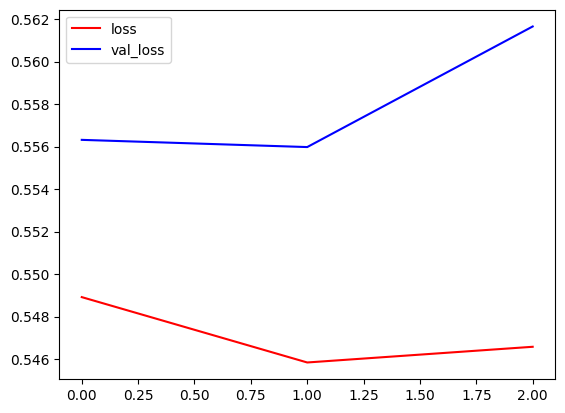

In [130]:
plt.plot(r.history['loss'],color = 'red', label = 'loss')
plt.plot(r.history['val_loss'], color = 'blue', label ='val_loss')
plt.legend()
plt.plot()

# 6. Metric Performance
---
https://mmuratarat.github.io/2020-01-25/multilabel_classification_metrics

In [131]:
y_pred = model.predict(x_test)

40/40 [==============================] - 3s 53ms/step


In [132]:
y_test

<tf.Tensor: shape=(1250, 4), dtype=int64, numpy=
array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       ...,
       [0, 0, 0, 1],
       [0, 1, 0, 1],
       [1, 0, 1, 0]])>

In [133]:
for i in range(0, y_pred.shape[0]):
  arr_thresholded = np.where(y_pred[i] > 0.5, int(1), int(0))
  y_pred[i] = arr_thresholded

In [134]:
y_true = y_test

In [135]:
# Accuracy (akurasi yang harus sama persis-> Exact Match Ratio)
accuracy = accuracy_score(y_true, y_pred)
accuracy

0.3776

In [136]:
def Accuracy_hamming(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        temp += sum(np.logical_and(y_true[i], y_pred[i])) / sum(np.logical_or(y_true[i], y_pred[i]))
    return temp / y_true.shape[0]

Accuracy_hamming(y_true, y_pred)


0.5867999999999999

In [137]:
# Hamming Loss (Jumlah beda antara prediksi dengan asli dibagi dengan total hasil prediksi)
# contoh
# prediksi:
# [[1 1 1 0]
#  [1 1 1 1]
#  [0 0 0 1]]

# Aslinya
# [[1. 0. 1. 0.]
#  [1. 0. 1. 0.]
#  [1. 0. 0. 0.]]

# maka banyak beda = 5, total hasil prediksi = 12
hamming_loss_value = hamming_loss(y_true, y_pred)
hamming_loss_value

0.279

In [138]:
y_test_mini = y_test[2:5]
y_pred_mini = y_pred[2:5]
print(y_test_mini)
print(y_pred_mini)

tf.Tensor(
[[0 0 0 1]
 [1 0 0 0]
 [1 0 1 0]], shape=(3, 4), dtype=int64)
[[1. 0. 1. 0.]
 [1. 0. 1. 0.]
 [1. 0. 1. 0.]]


In [139]:
# Precision, Recall, and F1-score
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
print(precision,)
print(recall)
print(f1)

0.4751677394738052
0.4689031291210891
0.3958539622105594


In [140]:
# Jaccard Similarity (Jaccard Index)
jaccard = jaccard_score(y_true, y_pred, average='samples')
jaccard

0.5868

In [148]:
df_processed.columns

Index(['terms', 'titles', 'abstracts', 'cs.LG', 'cs.AI', 'stat.ML', 'cs.CV'], dtype='object')

In [147]:
sum(y_true)

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([993, 200, 623, 328])>

In [141]:
sklearn.metrics.multilabel_confusion_matrix(y_true, y_pred)

array([[[   5,  252],
        [   8,  985]],

       [[1039,   11],
        [ 198,    2]],

       [[ 123,  504],
        [  92,  531]],

       [[ 913,    9],
        [ 321,    7]]])